In [1]:
import tensorflow as tf
import numpy as np
from utils.model import EncDec
from utils import seg_utils
from matplotlib import pyplot as plt
from PIL import Image
import os, cv2
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
# these functions are used to guarantee the dimensions H and W of images to be multiples of 8
def load_img(file):
    img = np.asarray(Image.open(file))
    img = np.expand_dims(cv2.resize(img, (img.shape[1] // 8 * 8, img.shape[0] // 8 * 8)), axis=0) / 255
    return img

def resize_seg(img):
    img = cv2.resize(img, (img.shape[1] // 8 * 8, img.shape[0] // 8 * 8), interpolation=cv2.INTER_LINEAR)
    return img

In [3]:
# build the model
enc_dec = EncDec()
ckpt = tf.train.Checkpoint(net=enc_dec)

# initialize the model parameters
x = load_img('figures/content/tubingen.jpg')
outputs = enc_dec(x)

# load the parameter values from the checkpoint
ckpt.restore('ckpt/ckpt')



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [4]:
# Parameter setting for the iterative algorithm:

# In the returned dictionary, the values for the keys '0', '1', '2', and '3' correspond to the parameters for feature updating
# at the layers relu1_1, relu2_1, relu3_1, and relu4_1, respectively.

# The values include 'lr' for learning rate, 'lamb' for lambda weight, and 'n_iter' for number of iterations for feature update.
# Empirically, the default values of 'lr' and 'n_iter' need not to be changed. However, if a stylized image is ruined, you might
# want to change the values of 'lamb', especially for relu3_1 and relu4_1. 
# For example, try conservative values lamb=[1e4, 2.5e3, 2.5e2, 2.5e1] when stylization fails under the default ones.

def iter_kargs(n_iter=[5,10,10,10], lr=[0.01]*4, lamb=[1e4, 1e4, 1e3, 1e2]): 
    return {
            0: {'lr':lr[0], 'lamb':lamb[0], 'n_iter':n_iter[0]},
            1: {'lr':lr[1], 'lamb':lamb[1], 'n_iter':n_iter[1]},
            2: {'lr':lr[2], 'lamb':lamb[2], 'n_iter':n_iter[2]},
            3: {'lr':lr[3], 'lamb':lamb[3], 'n_iter':n_iter[3]}
           }

# style transfer without segmentation specification

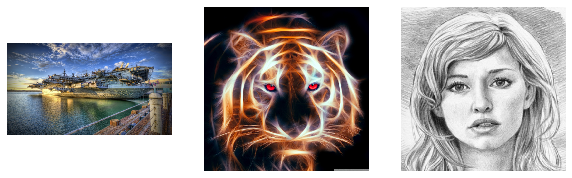

In [5]:
cont_img = load_img('figures/content/ship.png')
style_img1 = load_img('figures/style/glowing_tiger.jpg')
style_img2 = load_img('figures/style/sketch.jpg')

fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(cont_img[0])
_ = ax[0].axis('off')
ax[1].imshow(style_img1[0])
_ = ax[1].axis('off')
ax[2].imshow(style_img2[0])
_ = ax[2].axis('off')


In [6]:
# Use the member function "stylize" for stylization without segmentation specification
# The function interface is as follows:
# enc_dec.stylize(content image, [style image 1, style image 2, ...]
#                 enc_layers={layer: feature transformation},
#                 dec_layers={layer: feature transformation},
#                 iter_kargs=iter_kargs())

### 1. Four transformations can be chosen: adain, zca, ot, iter, iter is our iterative feature update
###    Only if 'iter' is used will 'iter_kargs' be considered. Otherwise, it is ignored.

### 2. Fine-to-coarse stylization: enc_layers={0:'iter', 1:'iter', 2:'iter', 3:'iter'}, dec_layers={}
###    This makes feature transformation happen sequentially from relu1_1, relu2_1, relu3_1, and relu4_1 layers.

### 3. Coarse-to-fine stylization: enc_layers={3:'iter'}, dec_layers={2:'iter', 1:'iter', 0:'iter'}
###    This makes feature transformation happen sequentially from relu4_1, relu3_1, relu2_1, and relu1_1 layers.
###    This is used by default.

### 4. Transformations can happen at whatever layers and the transformation methods can be mixedly used. 
### ex: enc_layers={2:'adain', 3:'zca'}, dec_layers={2:'iter', 1:'iter'}

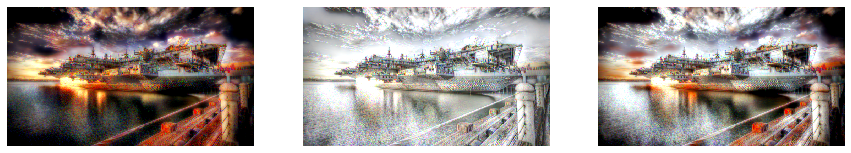

In [8]:
stylized_img1 = enc_dec.stylize(cont_img, [style_img1], enc_layers={3:'iter'}, 
                               dec_layers={2:'iter', 1:'iter', 0:'iter'}, 
                               iter_kargs=iter_kargs())
stylized_img2 = enc_dec.stylize(cont_img, [style_img2], enc_layers={3:'iter'}, 
                               dec_layers={2:'iter', 1:'iter', 0:'iter'}, 
                               iter_kargs=iter_kargs())
stylized_img3 = enc_dec.stylize(cont_img, [style_img1, style_img2], enc_layers={3:'iter'}, 
                               dec_layers={2:'iter', 1:'iter', 0:'iter'}, 
                               iter_kargs=iter_kargs())

fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(np.clip(stylized_img1[0], 0, 1))
_ = ax[0].axis('off')
ax[1].imshow(np.clip(stylized_img2[0], 0, 1))
_ = ax[1].axis('off')
ax[2].imshow(np.clip(stylized_img3[0], 0, 1))
_ = ax[2].axis('off')

# style transfer with segmentation

In [18]:
cont_img = load_img('figures/content/bright_room.png')
style_img = load_img('figures/style/dim_room.png')
cont_seg, style_seg = seg_utils.read_segmentations('figures/content_seg/bright_room.png',
                                                   'figures/style_seg/dim_room.png')
cont_seg = resize_seg(cont_seg)
style_seg = resize_seg(style_seg)

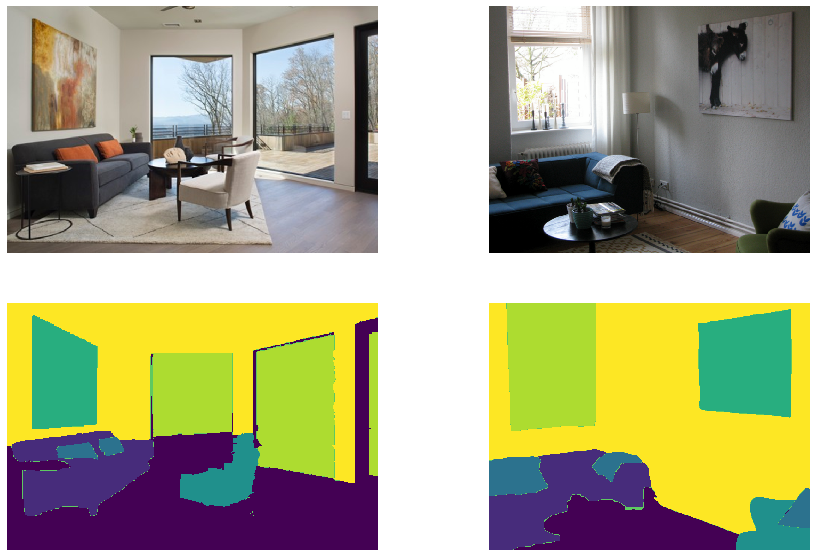

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax[0,0].imshow(cont_img[0])
_ = ax[0,0].axis('off')
ax[0,1].imshow(style_img[0])
_ = ax[0,1].axis('off')
ax[1,0].imshow(cont_seg)
_ = ax[1,0].axis('off')
ax[1,1].imshow(style_seg)
_ = ax[1,1].axis('off')

In [ ]:
# Use the member function stylize_seg for stylization with segmentation
# The interface is similar to stylize function except that the segmentations for content image and style image should be given.

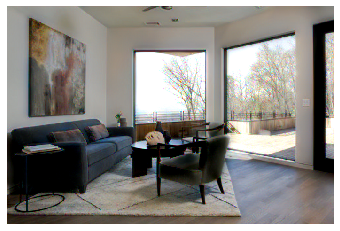

In [20]:
stylized_img = enc_dec.stylize_seg(cont_img, style_img, cont_seg, style_seg, enc_layers={3:'iter'}, 
                                   dec_layers={2:'iter', 1:'iter', 0:'iter'}, 
                                   iter_kargs=iter_kargs(lamb=[1e4, 2.5e3, 2.5e2, 2.5e1]))
plt.imshow(np.clip(stylized_img[0], 0, 1))
_ = plt.axis('off')

### another example

In [21]:
cont_img = load_img('figures/content/classic_car.png')
style_img = load_img('figures/style/yellow_car.png')
cont_seg, style_seg = seg_utils.read_segmentations('figures/content_seg/classic_car.png',
                                                   'figures/style_seg/yellow_car.png')
cont_seg = resize_seg(cont_seg)
style_seg = resize_seg(style_seg)

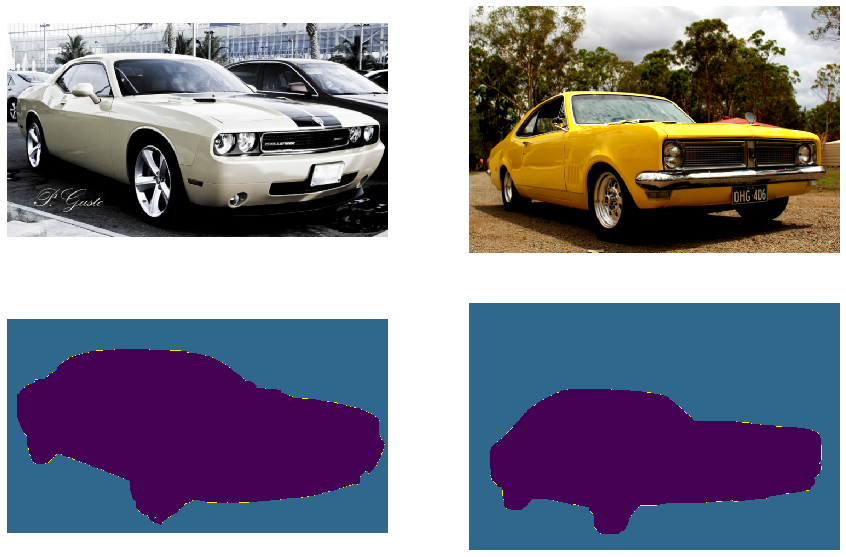

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax[0,0].imshow(cont_img[0])
_ = ax[0,0].axis('off')
ax[0,1].imshow(style_img[0])
_ = ax[0,1].axis('off')
ax[1,0].imshow(cont_seg)
_ = ax[1,0].axis('off')
ax[1,1].imshow(style_seg)
_ = ax[1,1].axis('off')

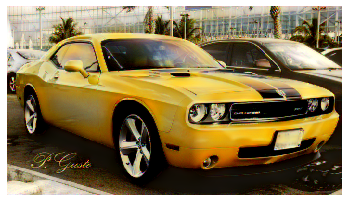

In [22]:
stylized_img = enc_dec.stylize_seg(cont_img, style_img, cont_seg, style_seg, enc_layers={3:'iter'}, 
                                   dec_layers={2:'iter', 1:'iter', 0:'iter'}, 
                                   iter_kargs=iter_kargs(lamb=[1e4, 2.5e3, 2.5e2, 2.5e1]))
plt.imshow(np.clip(stylized_img[0], 0, 1))
_ = plt.axis('off')